# 1.1.1.1 Binomial Trees

## Single Step

$$f = e^{-rT} [pf_u + (1-p)f_d]$$

where $p = \frac{e^{rT} - d}{u - d}$

- $f$ = option value today
- $f_u$ = option payoff in up state
- $f_d$ = option payoff in down state
- $r$ = risk-free rate
- $T$ = time to expiration
- $u$ = factor by which the stock price goes up
- $d$ = factor by which the stock price goes down
- $p$ = risk-neutral probability of the stock price going up
- $e$ = exponential function

In [7]:
import numpy as np

def option_value_binomialtree_singlestep(S_0, K, annualized_volatility, risk_free_rate, T, option_type='call'):
    f_u = np.exp(annualized_volatility * np.sqrt(T))
    f_d = 1 / f_u
    p = (np.exp(risk_free_rate * T) - f_d) / (f_u - f_d)

    S_up = S_0 * f_u
    S_down = S_0 * f_d

    # Calculate option payoffs properly based on option type
    if option_type.lower() == 'call':
        option_up = np.maximum(S_up - K, 0)
        option_down = np.maximum(S_down - K, 0)
    else:  # put option
        option_up = np.maximum(K - S_up, 0)
        option_down = np.maximum(K - S_down, 0)

    option_price = np.exp(-risk_free_rate * T) * (p * option_up + (1-p) * option_down)
    
    return {
            'steps': 1,
            'stock_tree': [[S_0], [S_up, S_down]],
            'option_tree': [[option_price], [option_up, option_down]],
            'parameters': {
                'f_u': f_u,
                'f_d': f_d,
                'p': p,
                'dt': T,
                'S_0': S_0,
            }
        }

# Example parameters
S0 = 100    # Initial stock price
K = 100     # Strike price
T = 1       # Time to maturity (in years)
r = 0.05    # Risk-free rate
annualized_volatility = 0.2 # Volatility
n = 12


option_value_binomialtree_singlestep(S_0=S0, K=K, annualized_volatility=annualized_volatility, risk_free_rate=r, T =T, option_type='put')

{'steps': 1,
 'stock_tree': [[100], [122.14027581601698, 81.87307530779819]],
 'option_tree': [[7.285227414695337], [0.0, 18.12692469220181]],
 'parameters': {'f_u': 1.2214027581601699,
  'f_d': 0.8187307530779818,
  'p': 0.5774931963561243,
  'dt': 1,
  'S_0': 100}}

# Multi Step

In [8]:
def option_value_binomialtree_multistep(S_0, K, annualized_volatility, risk_free_rate, T, steps, option_type='call'):
    # Calculate parameters
    dt = T / steps
    f_u = np.exp(annualized_volatility * np.sqrt(dt))
    f_d = 1 / f_u
    p = (np.exp(risk_free_rate * dt) - f_d) / (f_u - f_d)
    discount = np.exp(-risk_free_rate * dt)
    
    # Initialize stock and option price trees
    stock_tree = [[] for _ in range(steps + 1)]
    option_tree = [[] for _ in range(steps + 1)]
    
    # Build the stock price tree (forward)
    for i in range(steps + 1):
        for j in range(i + 1):
            # Stock price at node (i, j): i is time step, j is number of up moves
            stock_price = S_0 * (f_u ** j) * (f_d ** (i - j))
            stock_tree[i].append(stock_price)
            
            # At expiration, calculate option payoffs
            if i == steps:
                if option_type.lower() == 'call':
                    option_tree[i].append(max(stock_price - K, 0))
                else:  # put option
                    option_tree[i].append(max(K - stock_price, 0))
    
    # Calculate option prices by backward induction
    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            # Option price at each node using risk-neutral valuation
            option_value = discount * (p * option_tree[i+1][j+1] + (1-p) * option_tree[i+1][j])
            option_tree[i].append(option_value)
    
    return {
        'steps': steps,
        'stock_tree': stock_tree,
        'option_tree': option_tree,
        'parameters': {
            'f_u': f_u,
            'f_d': f_d,
            'p': p,
            'dt': dt,
            'S_0': S_0,
            'discount': discount
        },
        'option_price': option_tree[0][0]
    }

option_value_binomialtree_multistep(
    S_0=S0, K=K, annualized_volatility=annualized_volatility, risk_free_rate=r, T=T, steps=n, option_type='call'
)

{'steps': 12,
 'stock_tree': [[100.0],
  [94.39000224008954, 105.94342369612507],
  [89.09472522884109, 100.0, 112.24009024456674],
  [84.09651313930473,
   94.39000224008954,
   105.94342369612508,
   118.91099436471447],
  [79.37870063602693,
   89.0947252288411,
   100.00000000000001,
   112.24009024456674,
   125.97837858108483],
  [74.92555730849979,
   84.09651313930473,
   94.39000224008956,
   105.94342369612507,
   118.91099436471445,
   133.46580738566718],
  [70.72223522189253,
   79.37870063602693,
   89.0947252288411,
   100.00000000000001,
   112.24009024456672,
   125.97837858108484,
   141.39824580805154],
  [66.75471941018576,
   74.92555730849979,
   84.09651313930473,
   94.39000224008956,
   105.94342369612505,
   118.91099436471447,
   133.46580738566718,
   149.80214265531245],
  [63.009781146639824,
   70.72223522189253,
   79.37870063602693,
   89.0947252288411,
   100.0,
   112.24009024456674,
   125.97837858108483,
   141.39824580805157,
   158.70551869919134]

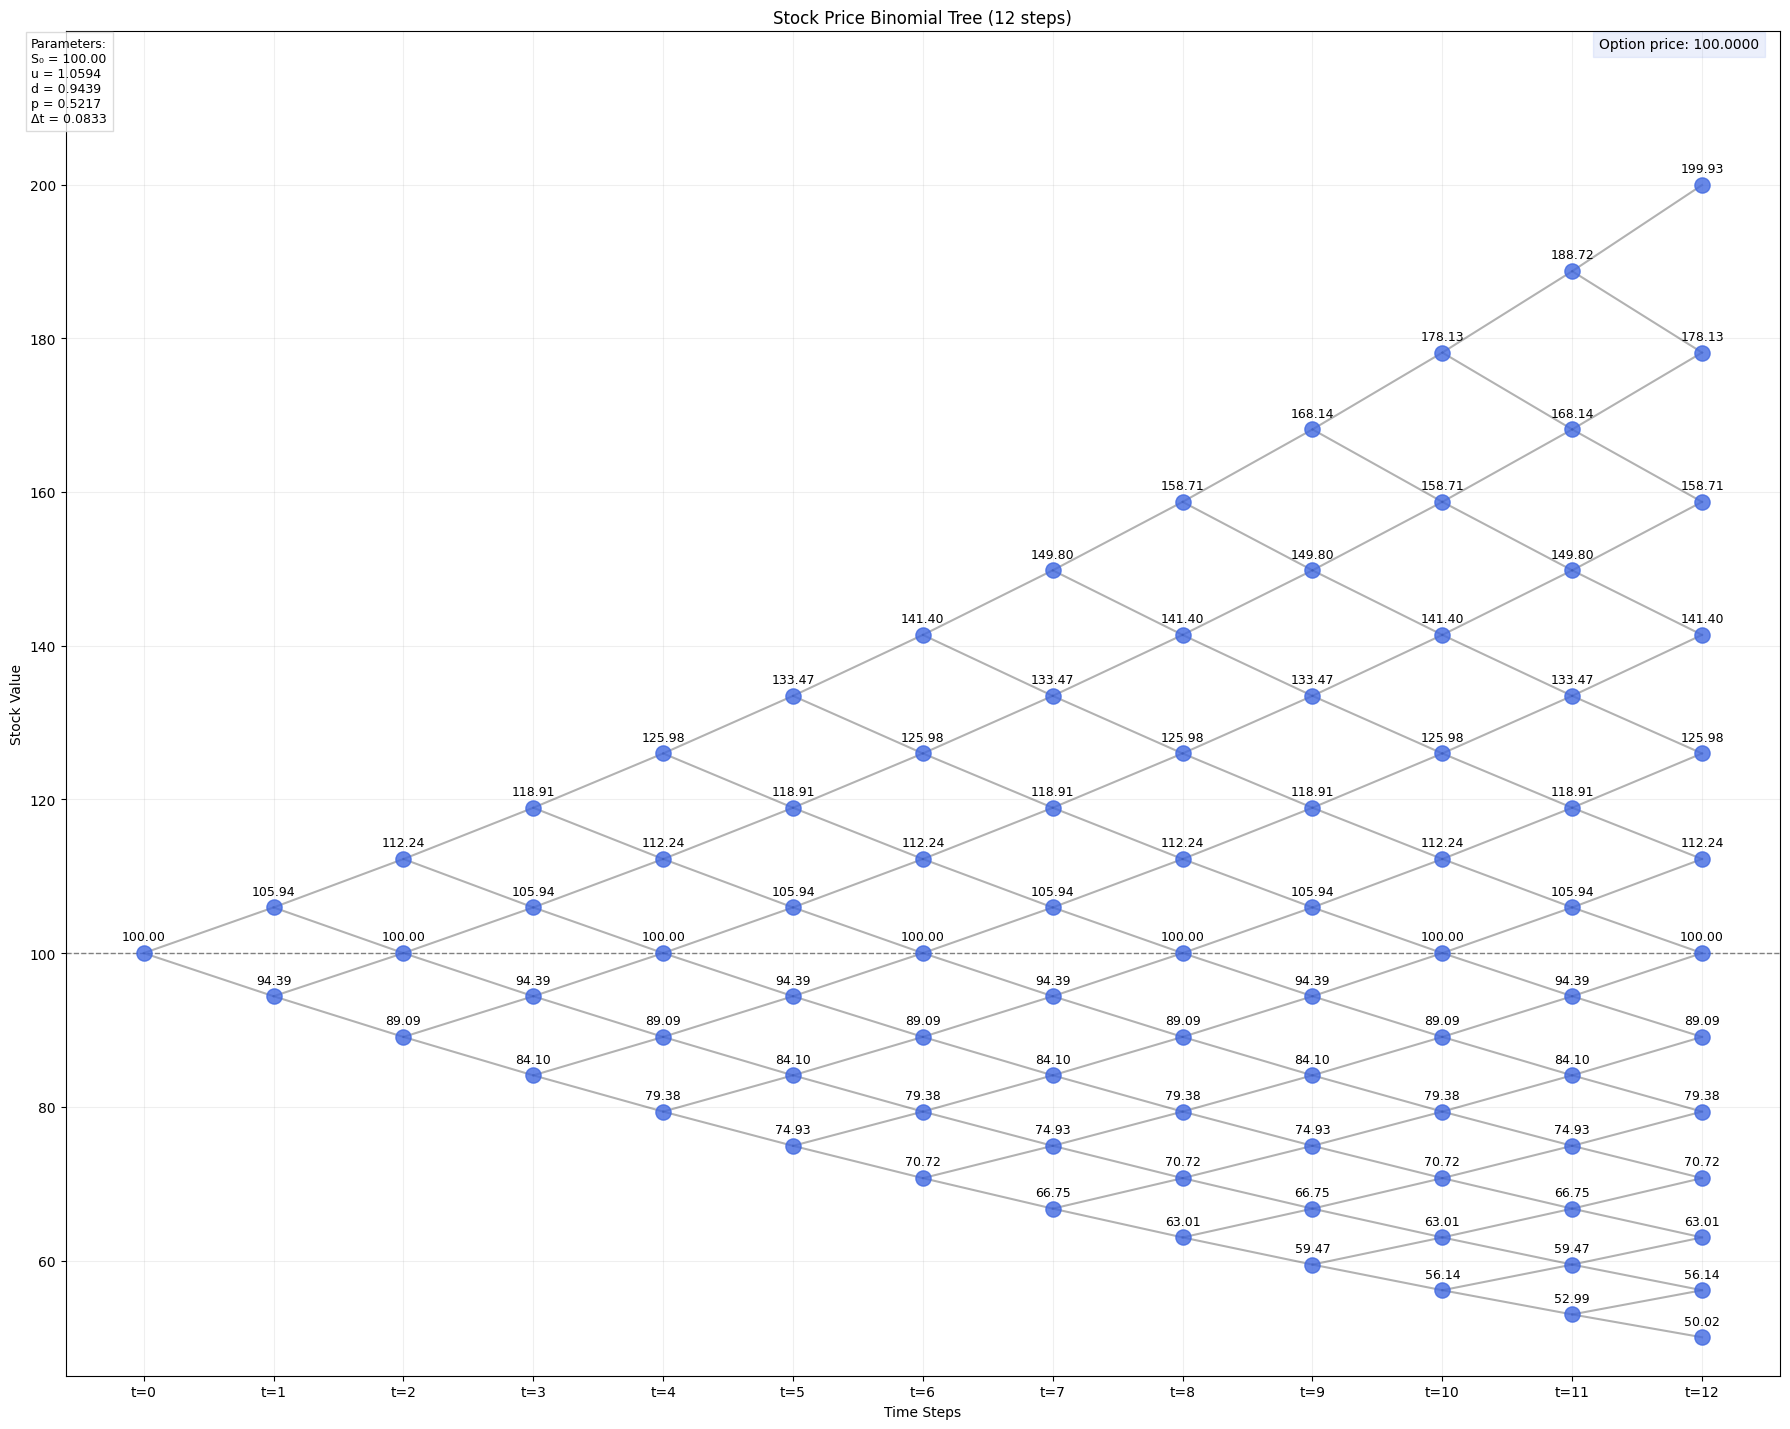

In [38]:
import matplotlib.pylab as plt

def visualize_binomial_tree_improved(tree_info, tree_type='stock'):
    """
    Visualize a binomial tree using actual values for the y-axis.
    
    Parameters:
    tree_info (dict): Dictionary containing the tree structure and parameters
    tree_type (str): 'stock' or 'option' to specify which tree to visualize
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    steps = tree_info['steps']
    
    if tree_type == 'stock':
        tree = tree_info['stock_tree']
        title = 'Stock Price Binomial Tree'
        node_color = 'royalblue'
    else:
        tree = tree_info['option_tree']
        title = 'Option Value Binomial Tree'
        node_color = 'seagreen'
    
    # Create figure with appropriate size
    fig_width = max(10, steps * 1.5)
    fig_height = max(7, steps * 1.2)
    plt.figure(figsize=(fig_width, fig_height))
    
    # Find min/max values for y-axis scaling
    all_values = [val for level in tree for val in level]
    min_val = min(all_values) * 0.9  # Add 10% padding
    max_val = max(all_values) * 1.1
    
    # Plot nodes and connections
    for i in range(steps + 1):
        # Calculate x-positions (evenly spaced time steps)
        x_positions = [i] * len(tree[i])
        
        # Use actual values for y-positions
        y_positions = tree[i]
        
        # Plot nodes
        plt.scatter(x_positions, y_positions, s=120, color=node_color, alpha=0.8, zorder=10)
        
        # Add value labels
        for j, value in enumerate(y_positions):
            if abs(value) < 1000:
                value_str = f'{value:.2f}'
            else:
                value_str = f'{value:.0f}'
                
            plt.annotate(value_str, (x_positions[j], y_positions[j]),
                        xytext=(0, 7), textcoords='offset points',
                        ha='center', va='bottom', fontsize=9, zorder=15)
        
        # Draw connections to child nodes
        if i < steps:
            for j, y_pos in enumerate(y_positions):
                # Draw up connection
                if j < len(tree[i+1]) - 1:
                    plt.plot([i, i+1], [y_pos, tree[i+1][j+1]], 
                             'k-', alpha=0.3, zorder=5)
                    
                    # Add up factor label for first step
                    if i == 0 and steps <= 3:
                        midpoint_x = (i + i+1) / 2
                        midpoint_y = (y_pos + tree[i+1][j+1]) / 2
                        plt.text(midpoint_x, midpoint_y, f"×{tree_info['parameters']['f_u']:.2f}",
                                fontsize=8, ha='center', va='bottom',
                                bbox=dict(facecolor='white', alpha=0.7, edgecolor=None))
                
                # Draw down connection
                if j < len(tree[i+1]):
                    plt.plot([i, i+1], [y_pos, tree[i+1][j]], 
                             'k-', alpha=0.3, zorder=5)
                    
                    # Add down factor label for first step
                    if i == 0 and steps <= 3:
                        midpoint_x = (i + i+1) / 2
                        midpoint_y = (y_pos + tree[i+1][j]) / 2
                        plt.text(midpoint_x, midpoint_y, f"×{tree_info['parameters']['f_d']:.2f}",
                                fontsize=8, ha='center', va='top',
                                bbox=dict(facecolor='white', alpha=0.7, edgecolor=None))
    
    # Set x-axis ticks and labels
    plt.xticks(range(steps + 1), [f't={i}' for i in range(steps + 1)])
    
    # Add information text box
    info_text = (
        f"Parameters:\n"
        f"S₀ = {tree_info['parameters']['S_0']:.2f}\n"
        f"u = {tree_info['parameters']['f_u']:.4f}\n"
        f"d = {tree_info['parameters']['f_d']:.4f}\n"
        f"p = {tree_info['parameters']['p']:.4f}\n"
        f"Δt = {tree_info['parameters']['dt']:.4f}"
    )
    
    plt.figtext(0.02, 0.97, info_text, fontsize=9, va='top',
               bbox=dict(facecolor='white', alpha=0.8, edgecolor='lightgray'))
    
    # Add option price for option tree
    if tree_type == 'option' and 'option_price' in tree_info:
        option_price = tree_info['option_price']
    else:
        option_price = tree[0][0]
    
    plt.axhline(option_price, color='gray', linestyle='--', linewidth=1)
    plt.figtext(
        0.98, 0.97, 
        f"Option price: {option_price:.4f}", 
        fontsize=10, ha='right', va='top',
        bbox=dict(facecolor='seagreen' if tree_type=='option' else 'royalblue', 
                 alpha=0.1, edgecolor='seagreen' if tree_type=='option' else 'royalblue')
    )
    
    plt.title(f"{title} ({steps} {'step' if steps == 1 else 'steps'})")
    plt.xlabel('Time Steps')
    plt.ylabel(f"{'Stock' if tree_type=='stock' else 'Option'} Value")
    plt.grid(True, alpha=0.2)
    plt.ylim(min_val, max_val)
    plt.tight_layout()
    
    plt.show()

# # For single-step tree
# tree_info = option_value_binomialtree_singlestep(100, 100, 0.2, 0.05, 1, 'call')
# visualize_binomial_tree_improved(tree_info, 'stock')
# plt.show()
# visualize_binomial_tree_improved(tree_info, 'option')
# plt.show()

# For multi-step tree
multi_tree_info = option_value_binomialtree_multistep(100, 100, 0.2, 0.05, 1, 12, 'put')
visualize_binomial_tree_improved(multi_tree_info, 'stock')
# visualize_binomial_tree_improved(multi_tree_info, 'option')